Seasonal ARIMA

In [ ]:
#PART I: Draw a plot chart to see if there is a trend. If there is, then performing differencing to detrend the data.

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

#Import data
prices=pd.read_csv("ai_count_no_outliers.csv",parse_dates=True,index_col=1)


#Take a look at what's inside of the data
prices.head()

#Transform date index from string type to date type
prices.index = pd.DatetimeIndex(prices.index).to_period('D')

In [ ]:
prices.head()

,Unnamed: 0,count
date,,
2020-01-01,0,13.0
2020-01-02,1,22.0
2020-01-03,2,24.0
2020-01-04,3,14.0
2020-01-05,4,6.0


In [ ]:
prices.drop(['Unnamed: 0'], inplace = True, axis = 1)

<AxesSubplot:xlabel='date'>

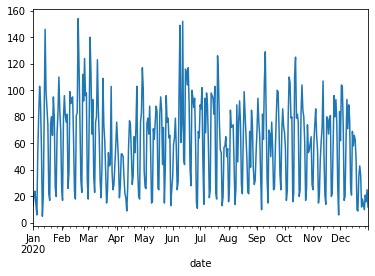

In [ ]:
#Draw plot chart
prices["count"].plot()

<AxesSubplot:xlabel='date'>

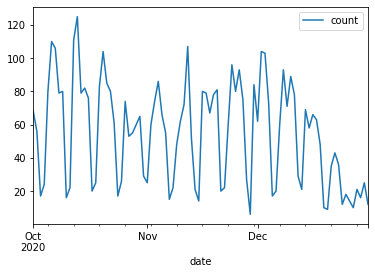

In [ ]:
#Use the last 3 months data to show seasonality more clearly
last3mon=prices.loc[prices.index>="2020-10-01"]
last3mon.plot()

In [ ]:
'''
#How to differencing data if there is a trend in original data?
from statsmodels.tsa.statespace.tools import diff 
diffprices=diff(prices, k_diff=1, k_seasonal_diff=None, seasonal_periods=1)
'''

In [ ]:
#No trend. So, no differencing for non-seasonal model.Therefore, k_diff is set to zero. 
#But needs seasonal differencing, because some monthly dividends are clearly more than other months.
#Thus, k_seasonal_diff=True, seasonal_periods=12 since there is a cycle every 12 months.

from statsmodels.tsa.statespace.tools import diff 
diffdvds=diff(last3mon, k_diff=1, k_seasonal_diff=True, seasonal_periods=1)
diffdvds

,count
date,
2020-10-03,-27.0
2020-10-04,46.0
2020-10-05,49.0
2020-10-06,-26.0
2020-10-07,-34.0
...,...
2020-12-27,0.0
2020-12-28,15.0
2020-12-29,-16.0


/home/mendu/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


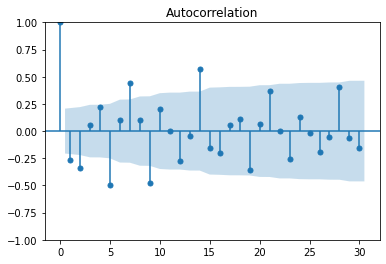

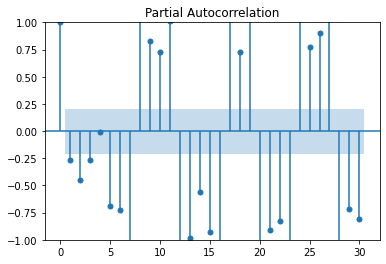

In [ ]:
#Part II: Draw ACF and PACF Plot Charts to identify the SARIMA Model
sm.graphics.tsa.plot_acf(diffdvds.values.squeeze(), lags=30) # You can change the lags value if you want to see more lags
sm.graphics.tsa.plot_pacf(diffdvds.values.squeeze(), lags=30)
plt.show()

In [ ]:
#Part III Run analysis model
#According to the ACF and PACF chart above, we identify AR(1) for non-seasonal model. 
#We identify MA(1) for the seasonal model. From ACF, we again confirm that there's a cycle every 12 months.

mod = sm.tsa.SARIMAX(last3mon, order=(1,0,0),seasonal_order=(0,1,1,2))
res = mod.fit()
print(res.summary())

#As you can see in the result, p-value for the coefficient of ar.L1 and ma.S.L12 are both significant. 
#The Lung-Box test is not significant, meaning that the population error is zero. So, ARIMA(1,0,0)X(0,1,1)12 is a good model.
#We choose dividends instead of diffdvd as the source data, because we want the SARIMAX do the differencing for us.
#If you use diffdvd as the source data, then seasonal_order=(0,0,1,12). Notice that D=0 if using diffdvd as the source data.


                                      SARIMAX Results                                      
Dep. Variable:                               count   No. Observations:                   92
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 2)   Log Likelihood                -425.844
Date:                             Sat, 23 Oct 2021   AIC                            857.687
Time:                                     20:53:15   BIC                            865.187
Sample:                                 10-01-2020   HQIC                           860.711
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5255      0.110      4.795      0.000       0.311       0.740
ma.S.L2       -0.9593      

In [ ]:
#Part IV: Forecasting

#If forecast one day ahead
print(res.forecast(1))

#If forecast two days ahead
print(res.forecast(2))

2021-01-01    34.488553
Freq: D, dtype: float64
2021-01-01    34.488553
2021-01-02    37.141665
Freq: D, Name: predicted_mean, dtype: float64


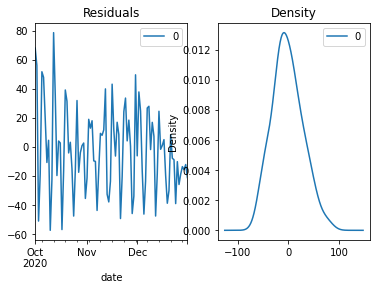

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(res.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


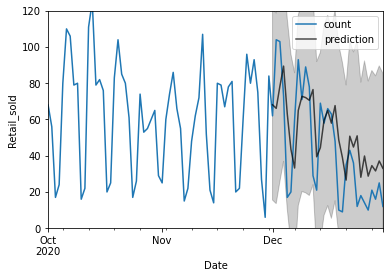

In [ ]:
pred = res.get_prediction(start=pd.to_datetime('2020-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = last3mon.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='prediction', alpha=.7, color = 'black')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
ax.set_ylim([0, 120])
plt.legend()
plt.show()

In [ ]:
y_predicted = pred.predicted_mean

In [ ]:
y_truth=prices.loc[prices.index>="2020-12-01"]
y_truth


,count
date,
2020-12-01,62.0
2020-12-02,104.0
2020-12-03,103.0
2020-12-04,73.0
2020-12-05,17.0
2020-12-06,20.0
2020-12-07,60.0
2020-12-08,93.0
2020-12-09,71.0


In [ ]:
#Converting columns into arrays
data_date = y_truth.index.to_numpy()
data_count = y_truth['count'].to_numpy()

#Converting into series
data_series = pd.Series(data = data_count, index = data_date)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(data_series, y_predicted)

0.9205350434470092

In [ ]:
y_predicted

date
2020-12-01    68.121749
2020-12-02    66.152466
2020-12-03    78.326921
2020-12-04    89.460481
2020-12-05    63.196039
2020-12-06    43.519534
2020-12-07    33.213178
2020-12-08    65.031347
2020-12-09    72.795296
2020-12-10    72.081925
2020-12-11    70.606925
2020-12-12    76.519800
2020-12-13    39.419899
2020-12-14    44.447992
2020-12-15    59.613210
2020-12-16    64.980937
2020-12-17    57.964915
2020-12-18    67.652413
2020-12-19    48.730828
2020-12-20    38.946852
2020-12-21    26.546256
2020-12-22    50.781102
2020-12-23    44.783306
2020-12-24    50.971329
2020-12-25    28.117651
2020-12-26    39.835027
2020-12-27    28.736589
2020-12-28    34.525642
2020-12-29    31.613740
2020-12-30    37.103198
2020-12-31    33.050592
Freq: D, Name: predicted_mean, dtype: float64

Reference: https://www.youtube.com/watch?v=l7jpmJLDmxQ